In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(os.getcwd() + '/crime-cast-forecasting-crime-categories'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

f:\MLP/crime-cast-forecasting-crime-categories\sample.csv
f:\MLP/crime-cast-forecasting-crime-categories\test.csv
f:\MLP/crime-cast-forecasting-crime-categories\train.csv


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings('ignore')

# Data Loading

In [4]:
train = pd.read_csv(os.getcwd() + "/crime-cast-forecasting-crime-categories/train.csv")
test = pd.read_csv(os.getcwd() + "/crime-cast-forecasting-crime-categories/test.csv")
sample = pd.read_csv(os.getcwd() + "/crime-cast-forecasting-crime-categories/sample.csv")

# EDA

In [5]:
train.shape

(20000, 22)

In [6]:
train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [8]:
train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [9]:
train.dtypes

Location                  object
Cross_Street              object
Latitude                 float64
Longitude                float64
Date_Reported             object
Date_Occurred             object
Time_Occurred            float64
Area_ID                  float64
Area_Name                 object
Reporting_District_no    float64
Part 1-2                 float64
Modus_Operandi            object
Victim_Age               float64
Victim_Sex                object
Victim_Descent            object
Premise_Code             float64
Premise_Description       object
Weapon_Used_Code         float64
Weapon_Description        object
Status                    object
Status_Description        object
Crime_Category            object
dtype: object

Value counts for Area_Name:
77th Street    1345
Pacific        1157
Central        1156
Southwest      1130
Southeast      1067
N Hollywood    1065
Hollywood      1014
Newton          999
Olympic         960
Wilshire        943
Rampart         931
West LA         910
Van Nuys        902
Harbor          872
Mission         870
Northeast       839
Topanga         792
West Valley     790
Devonshire      769
Hollenbeck      755
Foothill        734
Name: Area_Name, dtype: int64


Value counts for Victim_Sex:
M    8538
F    7176
X    1660
H       2
Name: Victim_Sex, dtype: int64


Value counts for Victim_Descent:
H    6143
W    4245
B    2881
X    1849
O    1603
A     427
K      83
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: Victim_Descent, dtype: int64


Value counts for Status:
IC    15236
AO     2597
AA     2054
JA       70
JO       43
Name: Status, dtype: int64




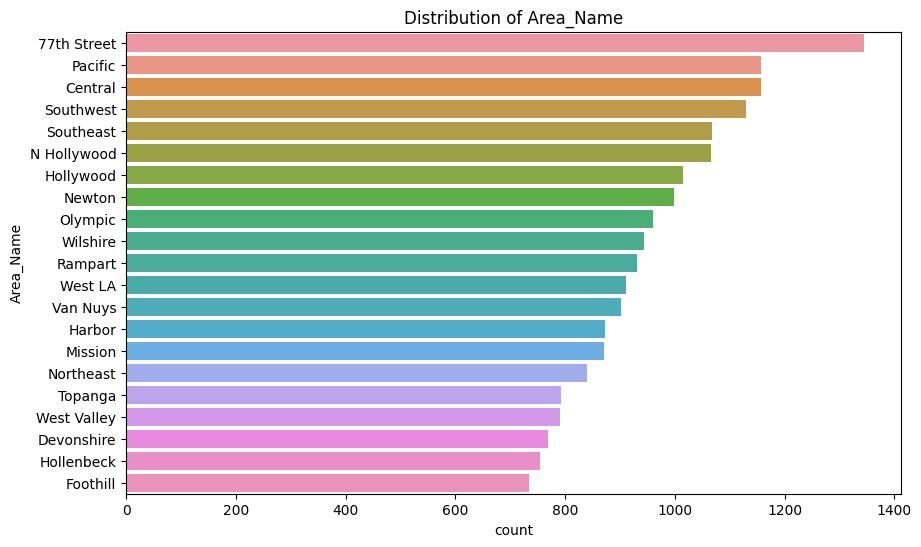

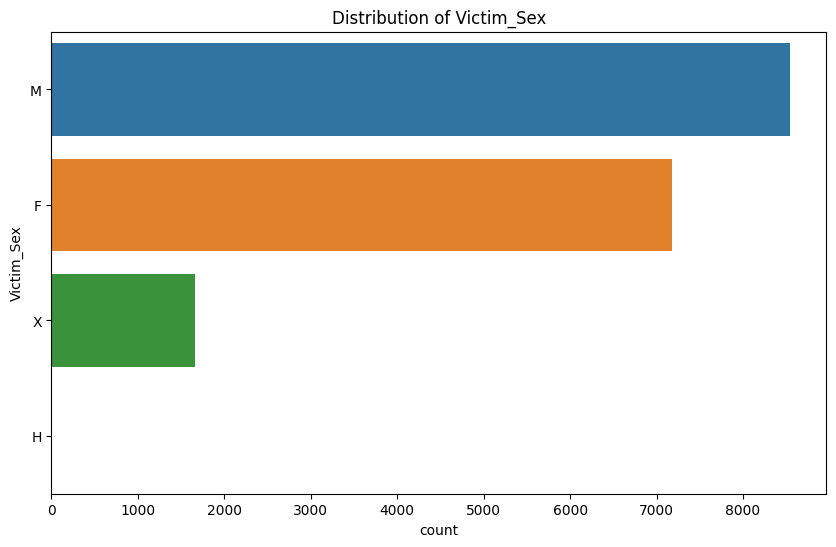

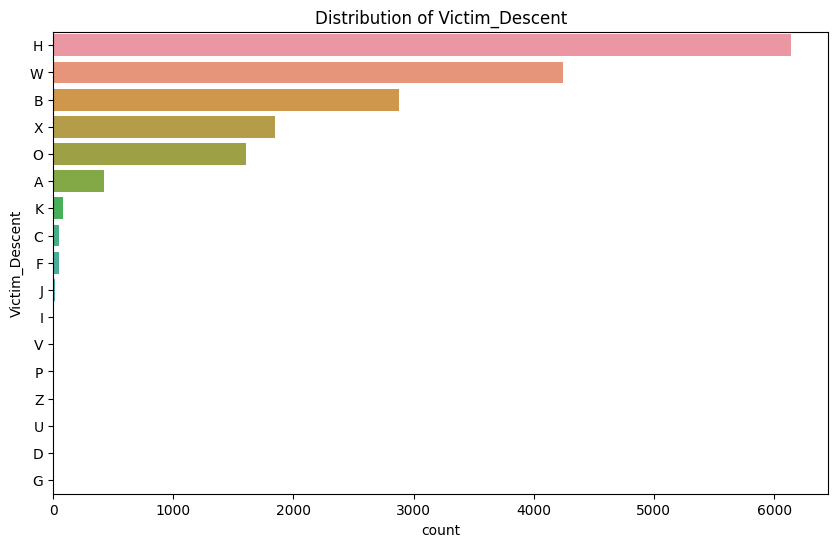

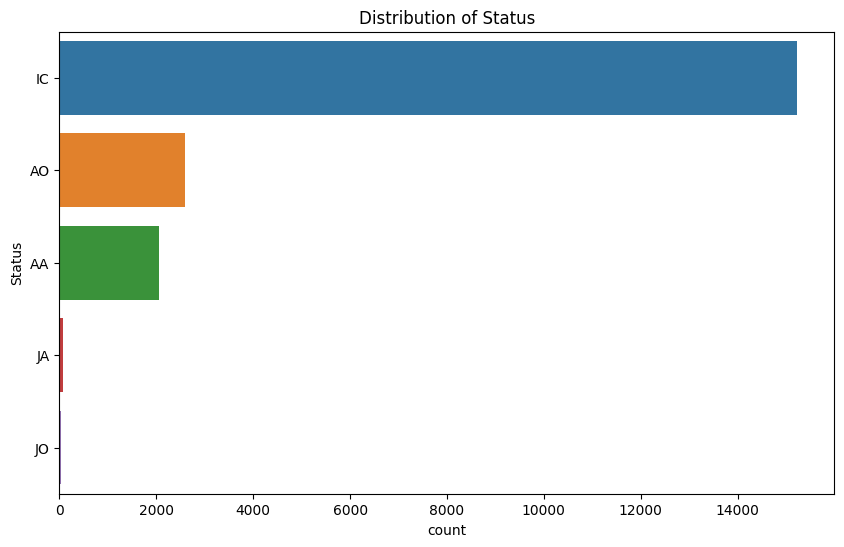

In [10]:
# Categorical features
categorical_features = ['Area_Name', 'Victim_Sex', 'Victim_Descent', 'Status']

# Analyze categorical features
for feature in categorical_features:
    print(f"Value counts for {feature}:")
    print(train[feature].value_counts())
    print("\n")

# Plot the distribution of categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train, y=feature, order=train[feature].value_counts().index)
    plt.title(f"Distribution of {feature}")
    plt.show()


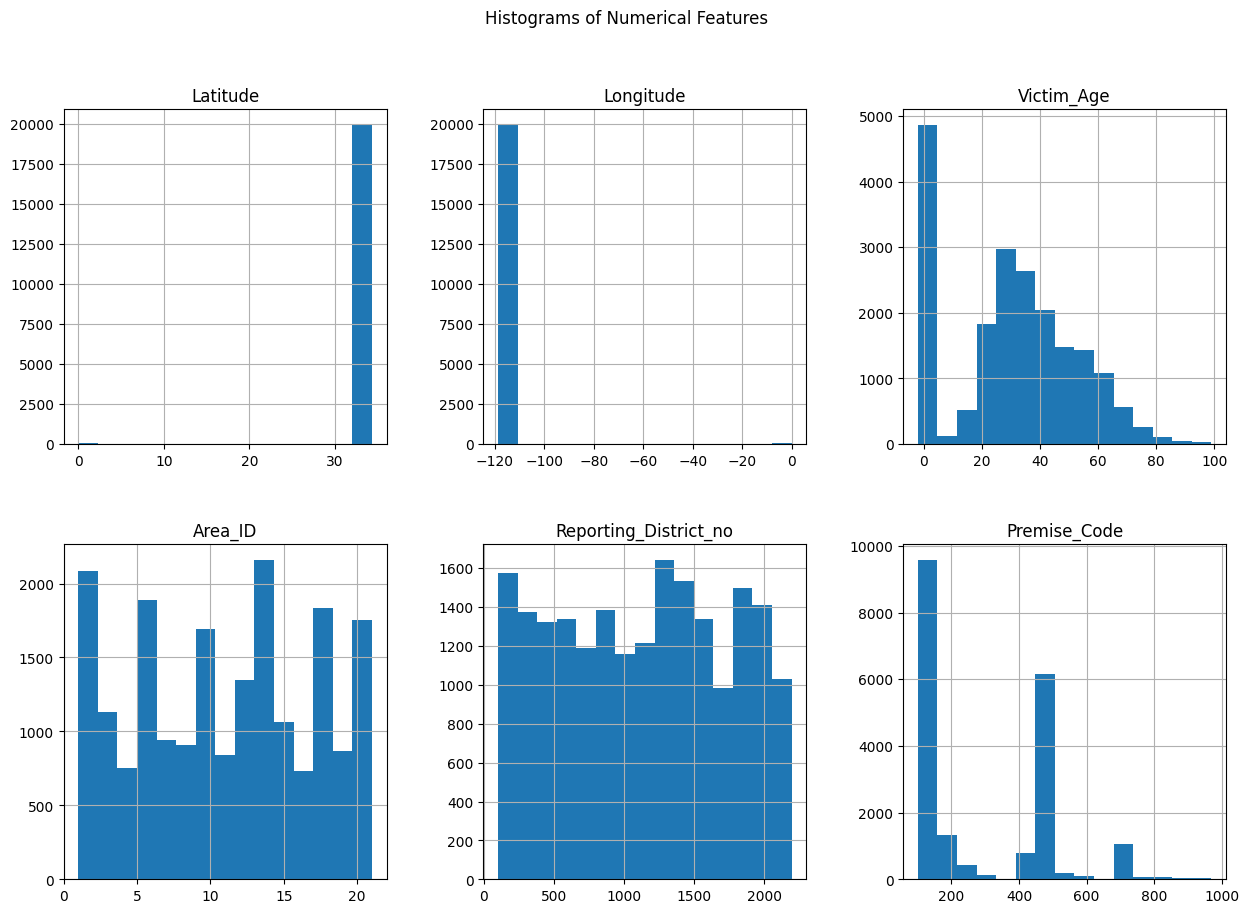

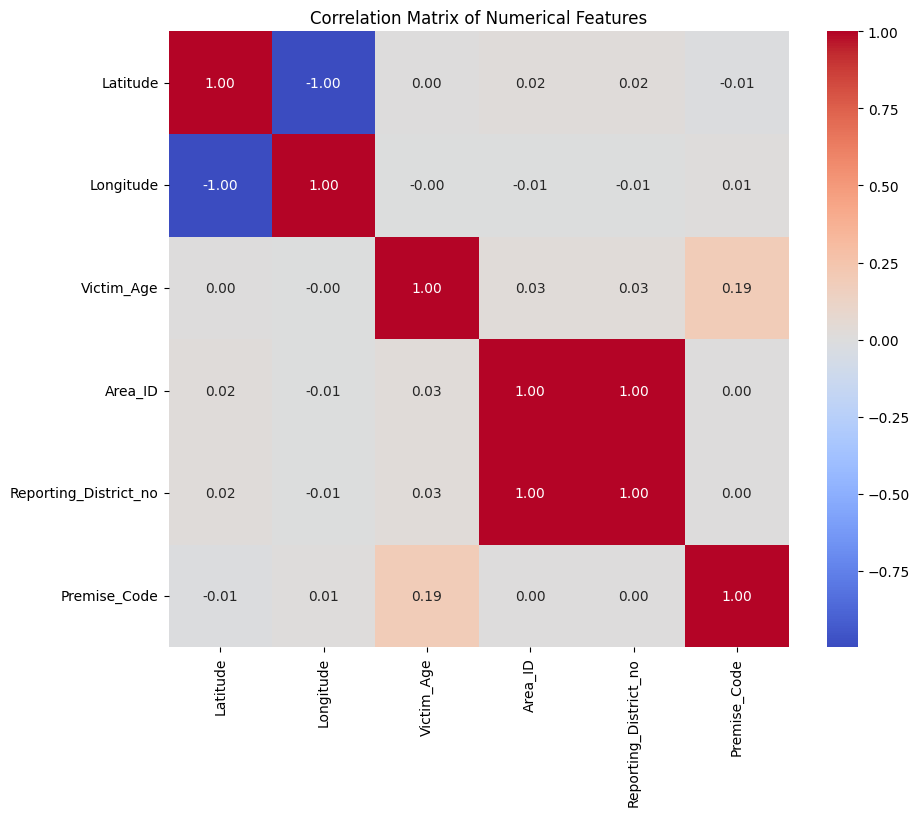

In [11]:
# Numerical features
numerical_features = ['Latitude', 'Longitude', 'Victim_Age', 'Area_ID', 'Reporting_District_no', 'Premise_Code']

# Plot histograms for numerical features
train[numerical_features].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Correlation matrix
corr_matrix = train[numerical_features].corr()

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


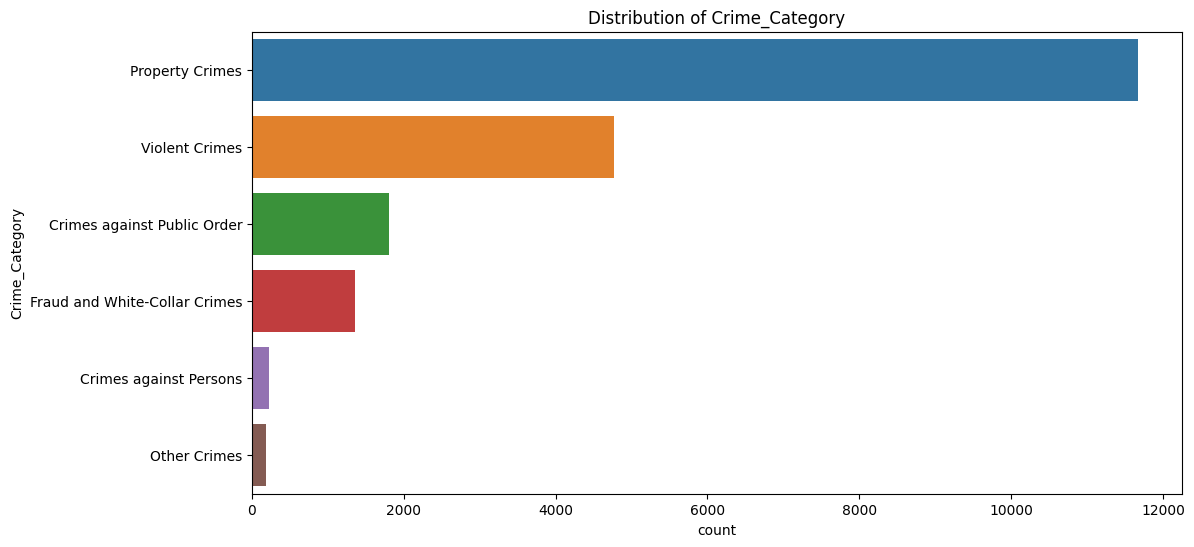

Property Crimes                  58.330
Violent Crimes                   23.835
Crimes against Public Order       9.040
Fraud and White-Collar Crimes     6.775
Crimes against Persons            1.125
Other Crimes                      0.895
Name: Crime_Category, dtype: float64


In [12]:
# Distribution of the target variable
plt.figure(figsize=(12, 6))
sns.countplot(data=train, y='Crime_Category', order=train['Crime_Category'].value_counts().index)
plt.title("Distribution of Crime_Category")
plt.show()

# Percentage distribution of Crime_Category
crime_category_distribution = train['Crime_Category'].value_counts(normalize=True) * 100
print(crime_category_distribution)


# Preprocessing - train data

In [13]:
missing_values = train.isnull().mean() * 100

# missing data
missing_values[missing_values > 0]

Cross_Street           82.760
Modus_Operandi         13.705
Victim_Sex             13.120
Victim_Descent         13.120
Premise_Description     0.025
Weapon_Used_Code       63.325
Weapon_Description     63.325
dtype: float64

In [14]:
# missing data more than 20%
missing_values[missing_values > 20]
# Need to delete these columns as imputation does not make sense on mojor amount of missing information.

Cross_Street          82.760
Weapon_Used_Code      63.325
Weapon_Description    63.325
dtype: float64

In [15]:
train_cleaned = train.drop(columns=['Cross_Street', 'Weapon_Used_Code', 'Weapon_Description'])

In [16]:
# can't have any specific value to impute, imputing with '0'
train_cleaned['Modus_Operandi'].fillna('0', inplace=True)

# Imputing Victim_Sex and Victim_Descent with mod. (Categorical Variables)
# M - 43%
train_cleaned['Victim_Sex'].fillna(train_cleaned['Victim_Sex'].mode()[0], inplace=True)

# H - 31%
train_cleaned['Victim_Descent'].fillna(train_cleaned['Victim_Descent'].mode()[0], inplace=True)

# STREET - 25%
train_cleaned['Premise_Description'].fillna(train_cleaned['Premise_Description'].mode()[0], inplace=True)


# Verify the missing value counts
train_cleaned.isnull().sum()

Location                 0
Latitude                 0
Longitude                0
Date_Reported            0
Date_Occurred            0
Time_Occurred            0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
Part 1-2                 0
Modus_Operandi           0
Victim_Age               0
Victim_Sex               0
Victim_Descent           0
Premise_Code             0
Premise_Description      0
Status                   0
Status_Description       0
Crime_Category           0
dtype: int64

In [17]:
# Dealing with date formats

train_cleaned['Date_Reported'] = pd.to_datetime(train_cleaned['Date_Reported'])
train_cleaned['Date_Occurred'] = pd.to_datetime(train_cleaned['Date_Occurred'])


train_cleaned['Year_Occurred'] = train_cleaned['Date_Occurred'].dt.year
train_cleaned['Month_Occurred'] = train_cleaned['Date_Occurred'].dt.month
train_cleaned['Day_Occurred'] = train_cleaned['Date_Occurred'].dt.day
train_cleaned['Hour_Occurred'] = train_cleaned['Time_Occurred'] // 100

In [18]:
# Drop Irrelevant Columns
train_cleaned = train_cleaned.drop(columns=['Location', 'Date_Reported', 'Date_Occurred', 'Time_Occurred'])

#Define Features and Target
X = train_cleaned.drop(columns=['Crime_Category'])
y = train_cleaned['Crime_Category']

In [19]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [20]:
# Define numerical and categorical columns
numeric_features = ['Latitude', 'Longitude', 'Victim_Age', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Premise_Code']
categorical_features = ['Area_Name', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Status']


In [21]:
# preprocessing pipeline for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [22]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing - test data

In [23]:
missing_values = test.isnull().mean() * 100

# missing data
missing_values[missing_values > 0]

Cross_Street           83.80
Modus_Operandi         13.68
Victim_Sex             12.86
Victim_Descent         12.86
Premise_Description     0.02
Weapon_Used_Code       63.06
Weapon_Description     63.06
dtype: float64

In [24]:
# missing data more tha 20%
missing_values[missing_values > 20]
# Need to delete these columns as imputation does not make sense on mojor amount of missing information.

Cross_Street          83.80
Weapon_Used_Code      63.06
Weapon_Description    63.06
dtype: float64

In [25]:
test_cleaned = test.drop(columns=['Cross_Street', 'Weapon_Used_Code', 'Weapon_Description'])

In [26]:
# can't have any specific value to impute, imputing with '0'
test_cleaned['Modus_Operandi'].fillna('0', inplace=True)

# Imputing Victim_Sex and Victim_Descent with mod. (Categorical Variables)
# M - 43%
test_cleaned['Victim_Sex'].fillna(test_cleaned['Victim_Sex'].mode()[0], inplace=True)

# H - 31%
test_cleaned['Victim_Descent'].fillna(test_cleaned['Victim_Descent'].mode()[0], inplace=True)

# STREET - 25%
test_cleaned['Premise_Description'].fillna(test_cleaned['Premise_Description'].mode()[0], inplace=True)


test_cleaned.isnull().sum()

Location                 0
Latitude                 0
Longitude                0
Date_Reported            0
Date_Occurred            0
Time_Occurred            0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
Part 1-2                 0
Modus_Operandi           0
Victim_Age               0
Victim_Sex               0
Victim_Descent           0
Premise_Code             0
Premise_Description      0
Status                   0
Status_Description       0
dtype: int64

In [27]:
# Dealing with date formats

test_cleaned['Date_Reported'] = pd.to_datetime(test_cleaned['Date_Reported'])
test_cleaned['Date_Occurred'] = pd.to_datetime(test_cleaned['Date_Occurred'])


test_cleaned['Year_Occurred'] = test_cleaned['Date_Occurred'].dt.year
test_cleaned['Month_Occurred'] = test_cleaned['Date_Occurred'].dt.month
test_cleaned['Day_Occurred'] = test_cleaned['Date_Occurred'].dt.day
test_cleaned['Hour_Occurred'] = test_cleaned['Time_Occurred'] // 100

In [28]:
# Drop Irrelevant Columns
test_cleaned = test_cleaned.drop(columns=['Location', 'Date_Reported', 'Date_Occurred', 'Time_Occurred'])

In [29]:
X_test = test_cleaned
y_validate = label_encoder.inverse_transform(y_validate)

# Model Training

LogisticRegression

In [30]:
lr_param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['saga', 'lbfgs'],
}
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=4000))
])
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Victim_Age',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Premise_Code']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Area_Name',
                                                                          'Modus_Operandi',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Status'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=4000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1.0, 10.0],
                         'classifier__solver': ['saga', 'lbfgs']},
             scoring='accuracy')

In [31]:
lr_best_model = lr_grid_search.best_estimator_
y_pred = lr_best_model.predict(X_validate)
y_pred = label_encoder.inverse_transform(y_pred)

In [32]:
accuracy_lr = accuracy_score(y_validate, y_pred)
accuracy_lr

0.81475

In [33]:
# classification report
print(classification_report(y_validate, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.50      0.03      0.06        32
  Crimes against Public Order       0.71      0.36      0.48       374
Fraud and White-Collar Crimes       0.82      0.70      0.76       267
                 Other Crimes       0.23      0.09      0.13        35
              Property Crimes       0.89      0.94      0.91      2303
               Violent Crimes       0.68      0.77      0.72       989

                     accuracy                           0.81      4000
                    macro avg       0.64      0.48      0.51      4000
                 weighted avg       0.81      0.81      0.80      4000



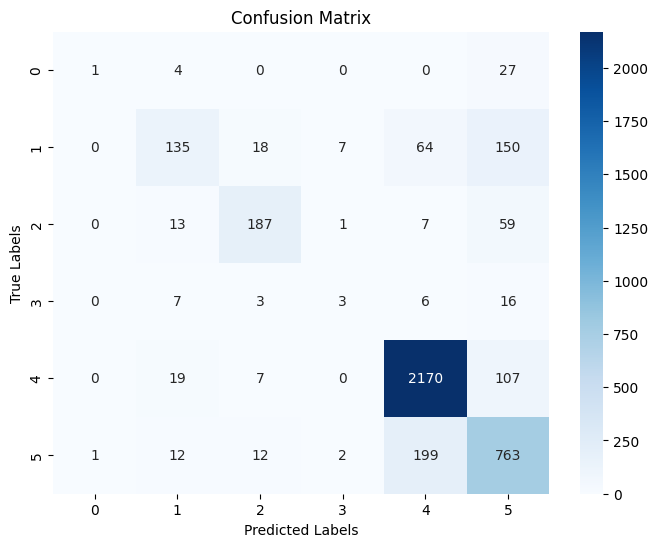

In [34]:
# confusion matrix

conf_matrix = confusion_matrix(y_validate, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=lr_best_model.classes_, yticklabels=lr_best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [35]:
y_lr = lr_best_model.predict(X_test)
y_lr = label_encoder.inverse_transform(y_lr)

RandomForestClassifier

In [36]:
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Victim_Age',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Premise_Code']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='mo...nt')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Area_Name',
                                                                          'Modus_Operandi',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Status'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [37]:
rf_best_model = rf_grid_search.best_estimator_
y_pred = rf_best_model.predict(X_validate)
y_pred = label_encoder.inverse_transform(y_pred)

In [38]:
accuracy_rf = accuracy_score(y_validate, y_pred)
accuracy_rf

0.7675

In [39]:
# classification report
print(classification_report(y_validate, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.50      0.12      0.20        32
  Crimes against Public Order       0.70      0.16      0.26       374
Fraud and White-Collar Crimes       0.69      0.58      0.63       267
                 Other Crimes       0.50      0.03      0.05        35
              Property Crimes       0.84      0.94      0.88      2303
               Violent Crimes       0.63      0.69      0.66       989

                     accuracy                           0.77      4000
                    macro avg       0.64      0.42      0.45      4000
                 weighted avg       0.76      0.77      0.74      4000



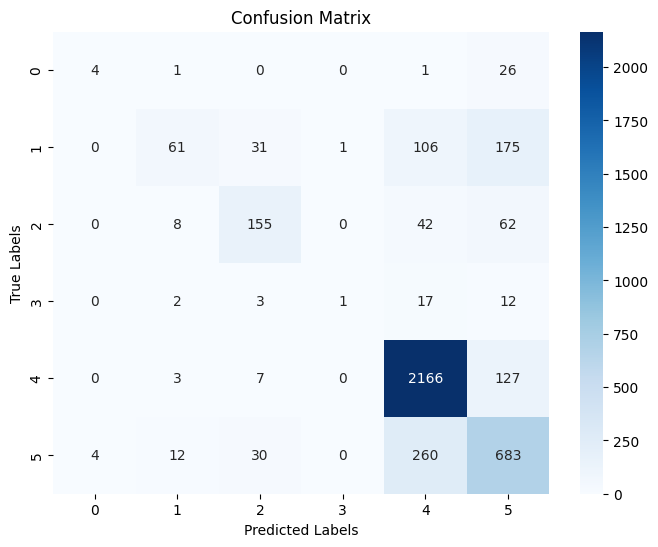

In [40]:
# confusion matrix

conf_matrix = confusion_matrix(y_validate, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_best_model.classes_, yticklabels=rf_best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [41]:
y_rf = rf_best_model.predict(X_test)
y_rf = label_encoder.inverse_transform(y_rf)

Support Vector Machine

In [42]:
svm_param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__kernel': ['linear', 'rbf', 'polynomial']
}
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Victim_Age',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Premise_Code']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Area_Name',
                                                                          'Modus_Operandi',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Status'])])),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1.0, 10.0],
                         'classifier__kernel': ['linear', 'rbf', 'polynomial']},
             scoring='accuracy')

In [43]:
svm_best_model = svm_grid_search.best_estimator_
y_pred = svm_best_model.predict(X_validate)
y_pred = label_encoder.inverse_transform(y_pred)

In [44]:
accuracy_svm = accuracy_score(y_validate, y_pred)
accuracy_svm

0.811

In [45]:
# classification report
print(classification_report(y_validate, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.50      0.19      0.27        32
  Crimes against Public Order       0.71      0.36      0.48       374
Fraud and White-Collar Crimes       0.78      0.72      0.75       267
                 Other Crimes       0.25      0.03      0.05        35
              Property Crimes       0.89      0.93      0.91      2303
               Violent Crimes       0.67      0.77      0.72       989

                     accuracy                           0.81      4000
                    macro avg       0.63      0.50      0.53      4000
                 weighted avg       0.80      0.81      0.80      4000



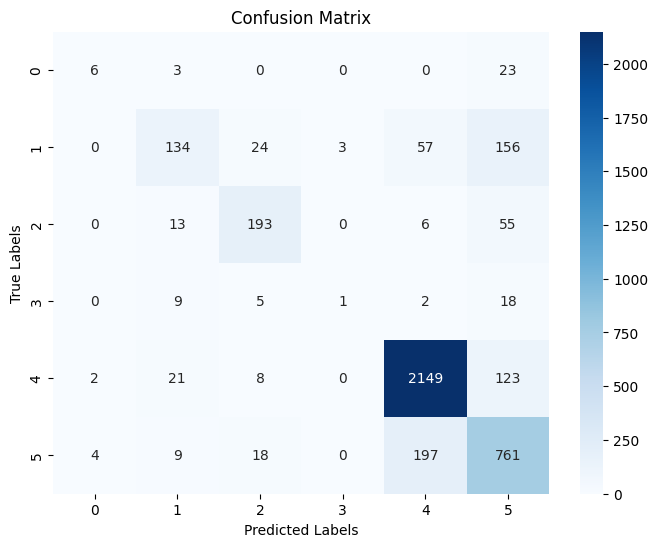

In [46]:
# confusion matrix

conf_matrix = confusion_matrix(y_validate, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=svm_best_model.classes_, yticklabels=svm_best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [47]:
y_svm = svm_best_model.predict(X_test)
y_svm = label_encoder.inverse_transform(y_svm)

# save submission.csv

In [48]:
submission = pd.DataFrame(columns=['ID', 'Crime_Category'])
submission['ID'] = [i for i in range(1,len(y_lr)+1)]
submission['Crime_Category'] = y_lr
submission.to_csv('submission.csv', index=False)

# Comparison

In [49]:
print('Logistic Regression', accuracy_lr)
print('Rendom Forest', accuracy_rf)
print('Support Vector Machine', accuracy_svm)

Logistic Regression 0.81475
Rendom Forest 0.7675
Support Vector Machine 0.811


In [50]:
#### Logistic Regression performs best out of all three models.